# Investigate ML Models

This is a simple and straightforward analysis that shows the effectiveness of this model's algorithms.

Here, we show the discriminative power of the `TokenRegressor` model, and explore several options for its construction parameters.

In [1]:
from os import chdir
import sys

# set path to allow module import
project_root = '/home/mike/litai'
if project_root not in sys.path:
    sys.path.append(project_root)

# operate in project root directory
chdir(project_root)

## Get Data

The first step is to create a dataset of positive and negative articles, pulling from actual articles provided by the Methuselah Foundation. We then split this into a training and testing subset. (A more rigorous analysis would involve cross-validation on multiple folds, but we're going to skip that.)

In [2]:
# initialize search engine to load in articles
# we already have these all downloaded, and have this really nice interface, so why not use it?

from litai import SearchEngine


engine = SearchEngine()

In [3]:
# load in positive articles
pos_pmids = open('data/senescence_pmids.txt', 'r').read().splitlines()
pos_articles = engine.search(pmids=pos_pmids, limit=None)

# show head
pos_articles.head()

,PMID,Date,Title,Abstract,Keywords
0,25152387,2014-11-15,Clinical features of Japanese patients with in...,The clinical characteristics of sIBM were rela...,Chronic denervation Clinical characteristics F...
1,28186729,2017-03-15,N-Terminal Hypothesis for Alzheimer's Disease.,"Although the amyloid (abeta peptide, Aβ) hypot...",Alzheimer’s disease Aβ peptide N-terminus frag...
2,27851729,2016-12-01,In vivo genome editing via CRISPR/Cas9 mediate...,Targeted genome editing via engineered nucleas...,
3,30279624,2018-09-01,Increased oxidative stress and coenzyme Q10 de...,"Aging populations are expanding worldwide, and...",centenarians cholesterol metabolism coenzyme Q...
4,34476070,2021-08-18,Monitoring phagocytic uptake of amyloid β into...,Phagocytosis by glial cells is essential to re...,


In [4]:
# load in random articles to use as negatives
num_pos = pos_articles.shape[0]
num_neg = num_pos * 3  # unbalance by a factor of 3:1
neg_articles = engine.search(limit=num_neg)

# show head
neg_articles.head()

,PMID,Date,Title,Abstract,Keywords
0,30840230,2019-09-01,From gut microbiota dysfunction to obesity: co...,Study of the interactions between the gut micr...,Diet Gut microbiota Nutrition Obesity Short-ch...
1,26022787,2015-06-01,The Sequencing of a College Degree during the ...,In this study we consider the health implicati...,childbirth life course longitudinal marriage o...
2,34772490,2021-12-01,Impact of Anti-HLA De Novo Donor Specific Anti...,The results of our meta-analysis show that ant...,
3,34610816,2021-10-05,Macular perfusion normative data acquired with...,The study provides the first detailed normativ...,Angiography Children Perfusion Retina Retinal ...
4,26335286,2015-09-29,A Red/Green Cyanobacteriochrome Sustains Its C...,"The second GAF domain of AnPixJ, AnPixJg2, a b...",


In [5]:
# check that pos and negative don't overlap
from numpy import intersect1d

assert(len(intersect1d(pos_articles['PMID'], neg_articles['PMID'])) < 0.01 * num_pos)

In [6]:
# split train / testing
from sklearn.model_selection import train_test_split
from numpy import concatenate, ones, zeros
from pandas import concat


# combine pos / neg articles, get labels
articles = concat((pos_articles, neg_articles))
labels = concatenate(
    (
        ones(num_pos),
        zeros(num_neg),
    )
)

# split train / test
X_train, X_test, y_train, y_test = train_test_split(articles, labels)

## Evaluate Models

Now that we have a train and test dataset, let's create a function that will let us investigate multiple underlying ML models, and show the effectiveness and metrics of each.

In [7]:
# create function to train models and plot results
from typing import Any

from matplotlib import pyplot
from matplotlib.ticker import PercentFormatter
from nptyping import NDArray
import seaborn
from sklearn.metrics import auc, precision_recall_curve, roc_curve

from litai.model import TokenRegressor


def train_model(model: Any = None) -> NDArray[(Any,), float]:
    """Train model, predict scores"""

    # train model
    kwargs = {'model': model} if model else {}
    model = TokenRegressor(**kwargs).fit(X_train, y_train)

    # use model to score articles
    y_pred = model.predict(X_test)

    # return
    return y_pred


def analyze_model(model: Any = None):

    # train model
    y_pred = train_model(model)

    # make sure plots are pretty
    seaborn.set_theme()

    # get values and metrics
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    # plot data
    fig_height = 6
    fig, ax = pyplot.subplots(1, 2, figsize=(2*fig_height, fig_height))
    ax[0].plot(100*fpr, 100*tpr)
    ax[1].plot(100*recall, 100*precision)

    # make labels
    label_fontsize = 14
    label_args = {'fontsize': label_fontsize}
    ax[0].set_xlabel('False-Positive Rate', **label_args)
    ax[0].set_ylabel('True-Positive Rate', **label_args)
    ax[0].set_title(f'ROC-AUC = {roc_auc:.2f}', **label_args)
    ax[1].set_xlabel('Recall', **label_args)
    ax[1].set_ylabel('Precision', **label_args)
    ax[1].set_title(f'PR-AUC = {pr_auc:.2f}', **label_args)

    # format labels
    for axis in ax:
        axis.yaxis.set_major_formatter(PercentFormatter())
        axis.xaxis.set_major_formatter(PercentFormatter())
        axis.set_xlim([0, 100])
        axis.set_ylim([0, 100])

    # draw plot
    fig.tight_layout()
    pyplot.show()

Let's use this function to evaluate a linear regression, a SVM, and XGBoost.

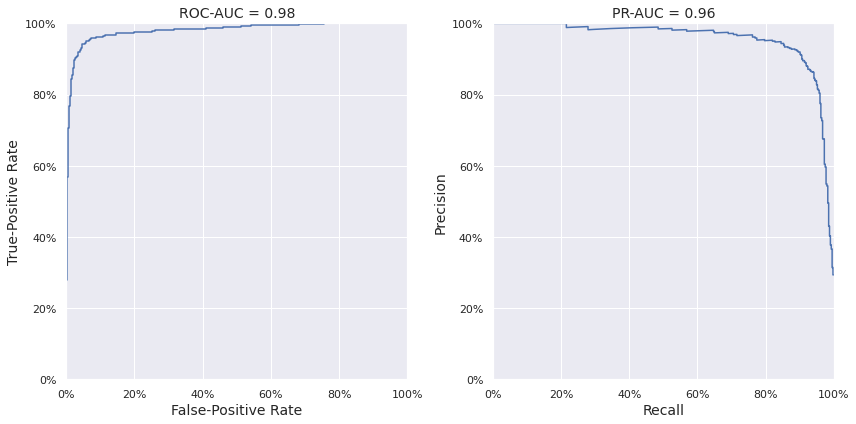

In [8]:
# try out linear regressor model
from sklearn.linear_model import LinearRegression


analyze_model(LinearRegression())

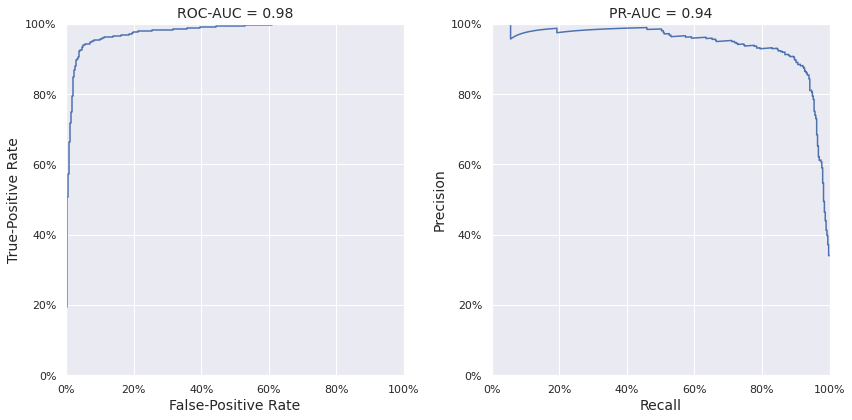

In [9]:
# try out SVM
from sklearn.svm import LinearSVR


analyze_model(LinearSVR(max_iter=1E4))

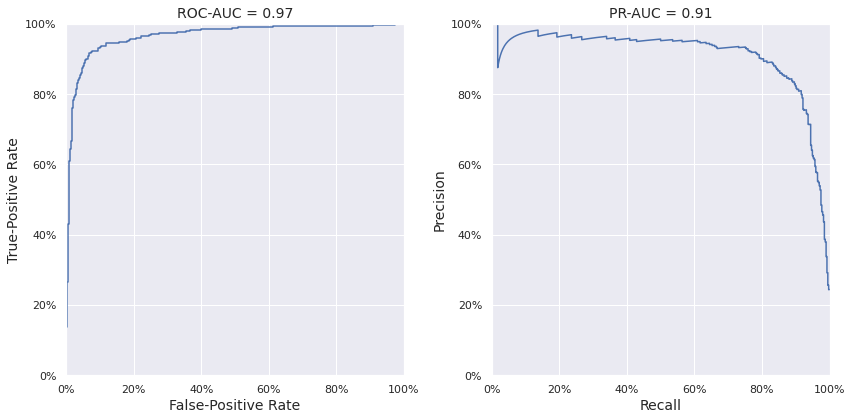

In [10]:
# try out xgboost
from xgboost import XGBRegressor


analyze_model(XGBRegressor())

## Compare to BERT

Let's compare our tokenization method to Google's BERT, using the sBERT derivative.

In [11]:
# redefine train_model() method to use BERT
from sentence_transformers import SentenceTransformer


def train_model(model: Any) -> NDArray[(Any,), float]:
    
    # use tokenizer
    text = TokenRegressor._get_text(X_train)
    encoder = SentenceTransformer('all-MiniLM-L6-v2')
    numeric = encoder.encode(text)

    # train ML model
    model.fit(numeric, y_train)

    # predict
    text = TokenRegressor._get_text(X_test)
    numeric = encoder.encode(text)
    return model.predict(numeric)

/home/mike/litai/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


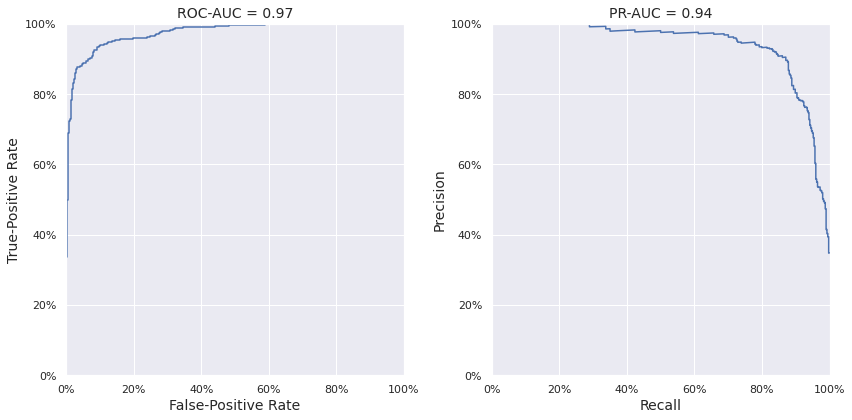

In [12]:
# try out linear regressor model
from sklearn.linear_model import LinearRegression


analyze_model(LinearRegression())

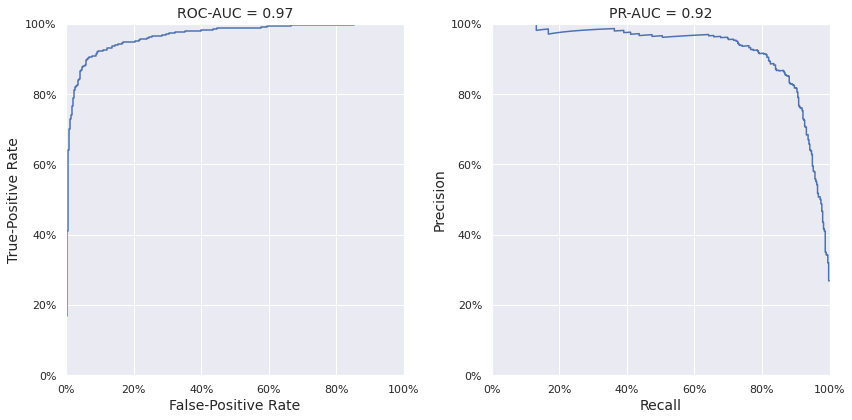

In [13]:
# try out SVM
from sklearn.svm import LinearSVR


analyze_model(LinearSVR(max_iter=1E4))

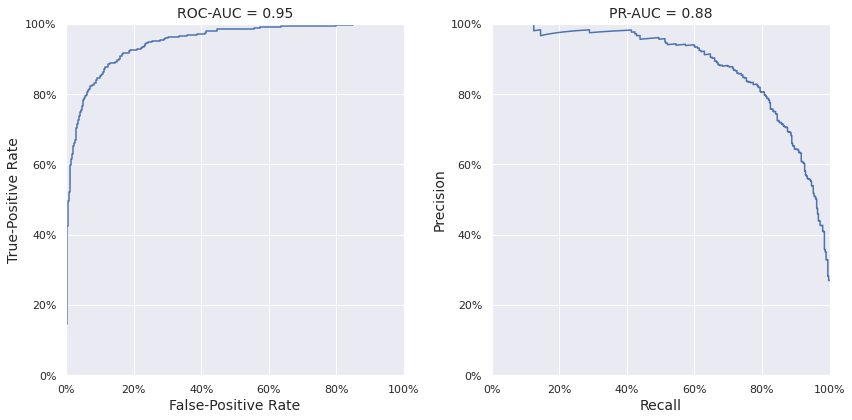

In [14]:
# try out xgboost
from xgboost import XGBRegressor


analyze_model(XGBRegressor())

## Conclusion

`LinearRegressor` is the top-performing model, and gets near-perfect accuracy.

`LinearRegressor` performs equally well with `BERT` and `vhash`, so we're going to stick with `vhash` for now, since it's faster.